In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [1]:

def read_file(url):
    '''this function is to read file from local path.'''
    with open(url) as f:
        df = pd.read_csv(url,decimal=',',skiprows=range(0,18),parse_dates=True)
        df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('___','').str.replace('_','')
        df['date']=pd.to_datetime(df['date'].astype('str'),format ='%Y%m%d')
        df=df.set_index(keys = 'date', drop = False, append = False, 
                   #verify_integrity=10, improve the performance
                   )
    return df

In [3]:
url='../data/TG_STAID002759.txt'
read_file(url)

<ipython-input-1-d51c5e69f459>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('___','').str.replace('_','')


,souid,date,tg,qtg
date,,,,
1876-01-01,127488,1876-01-01,22,0
1876-01-02,127488,1876-01-02,25,0
1876-01-03,127488,1876-01-03,3,0
1876-01-04,127488,1876-01-04,-58,0
1876-01-05,127488,1876-01-05,-98,0
...,...,...,...,...
2021-03-27,111448,2021-03-27,69,0
2021-03-28,111448,2021-03-28,77,0
2021-03-29,111448,2021-03-29,144,0


In [4]:
df.loc[(df.tg==(-9999)),'tg']=df['tg'].mean() ## replace the outlayer

In [5]:
df.index.unique()

DatetimeIndex(['1876-01-01', '1876-01-02', '1876-01-03', '1876-01-04',
               '1876-01-05', '1876-01-06', '1876-01-07', '1876-01-08',
               '1876-01-09', '1876-01-10',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='date', length=53051, freq=None)

In [6]:
def plot0(df,title,alpha=0.8):
    df.plot(figsize=(40,20))
    plt.title(title)
    #plt.xlabel('')
    sns.despine()
    plt.ylabel('# gt3')

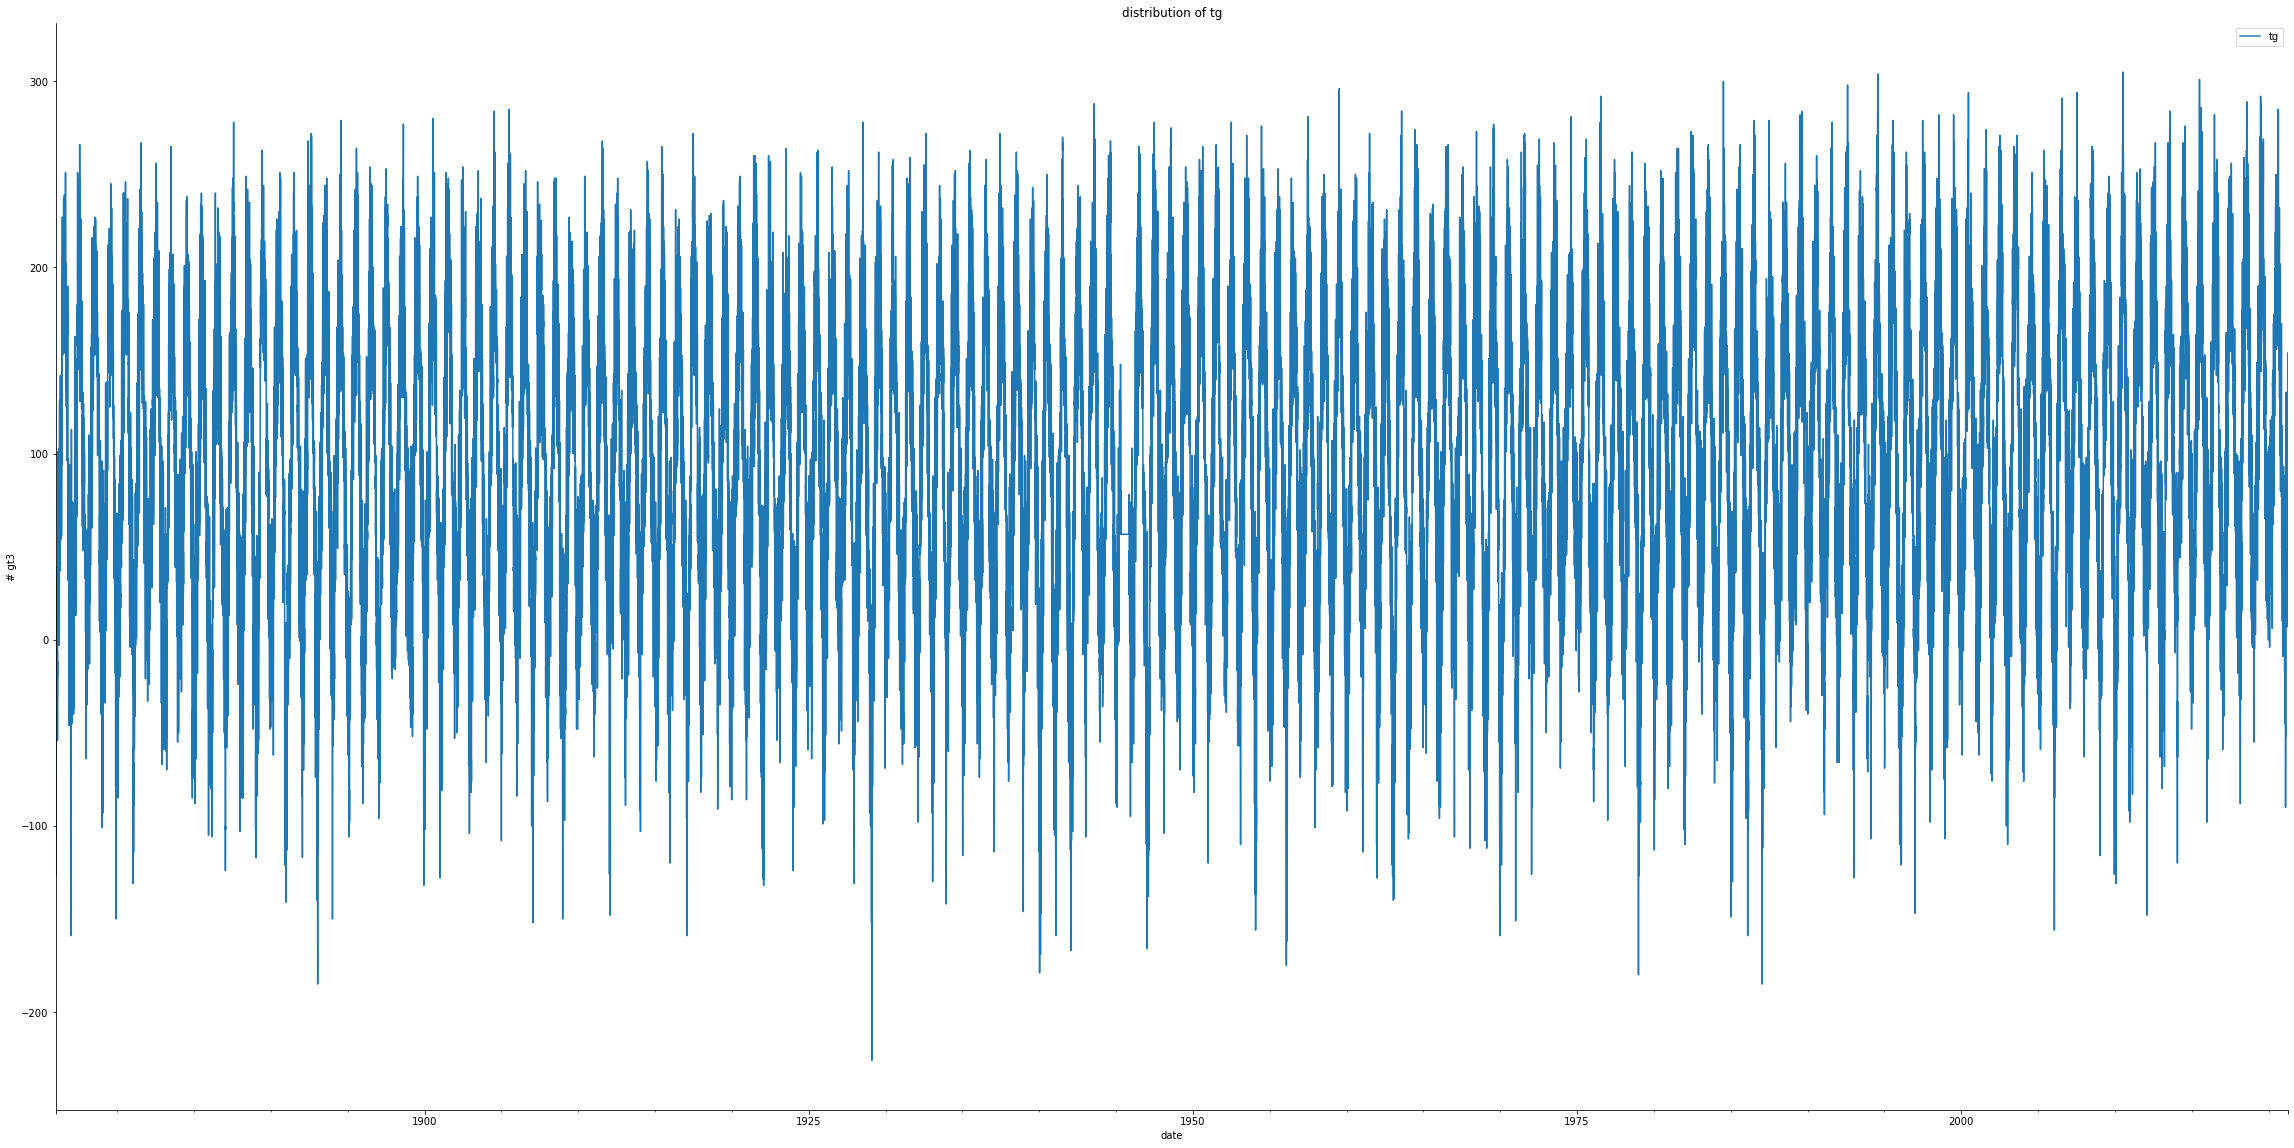

In [7]:
plot0(df[['tg']],'distribution of tg')

In [8]:
df.drop(columns=['souid','date','qtg'], axis=0,inplace=True)

In [9]:
df['timestamp'] = np.arange(len(df.index))

In [11]:
from sklearn.linear_model import LinearRegression

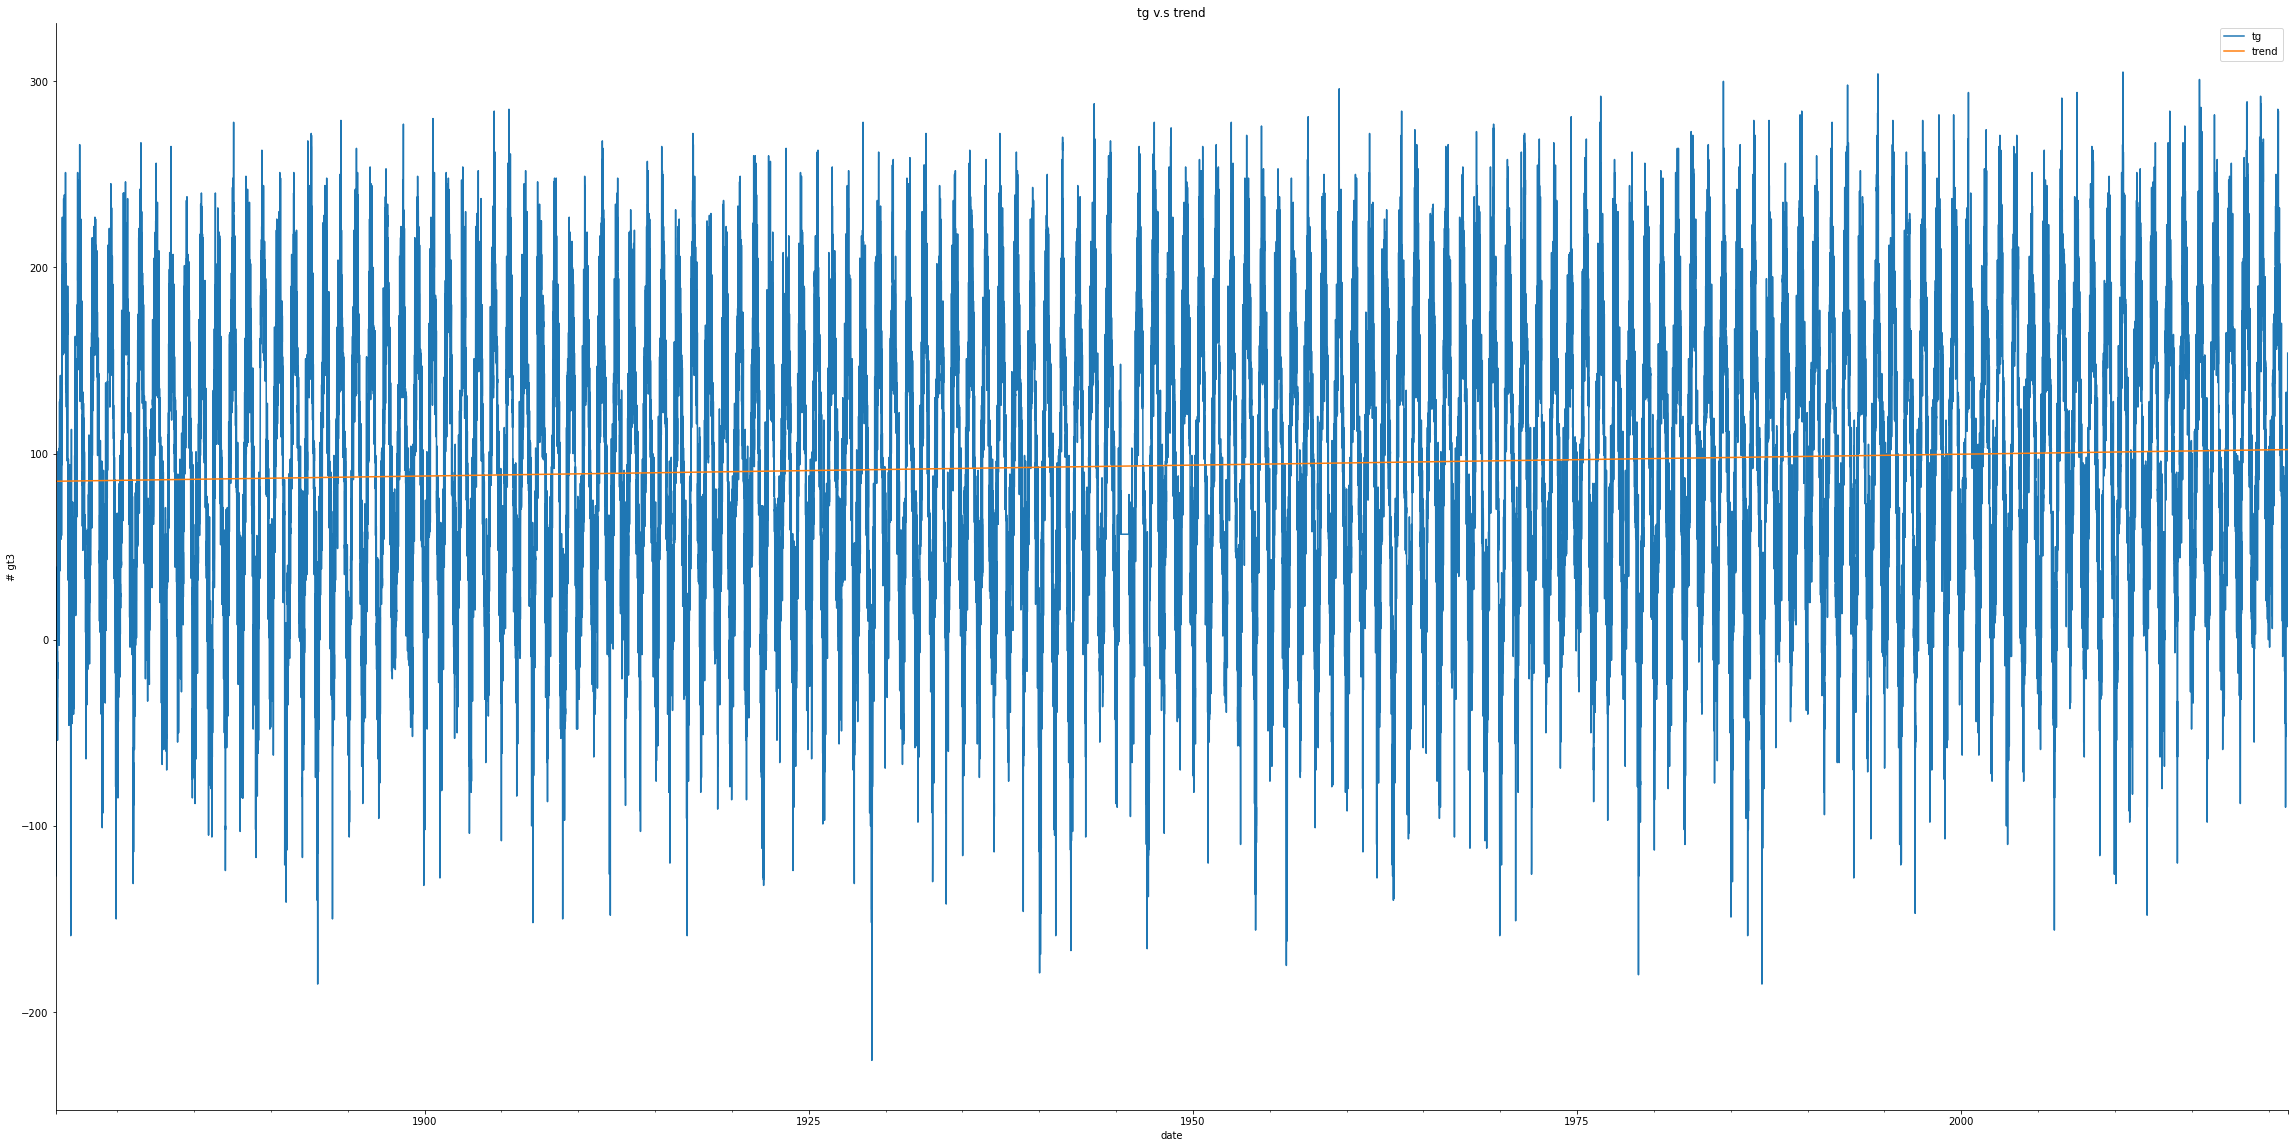

In [12]:
def train_model(X,y, model, **kwargs):
    m = model
    m.fit(X,y)
    pred = m.predict(X)
    return pred

X = df[['timestamp']]
y = df['tg']
model = LinearRegression()    
df['trend']=train_model(X,y, model)
plot0(df[['tg','trend']],'tg v.s trend')

In [14]:
seasonal_features = pd.get_dummies(df.index.month, prefix = "month_").set_index(df.index)

In [15]:
df=df.join(seasonal_features)

<AxesSubplot:xlabel='date'>

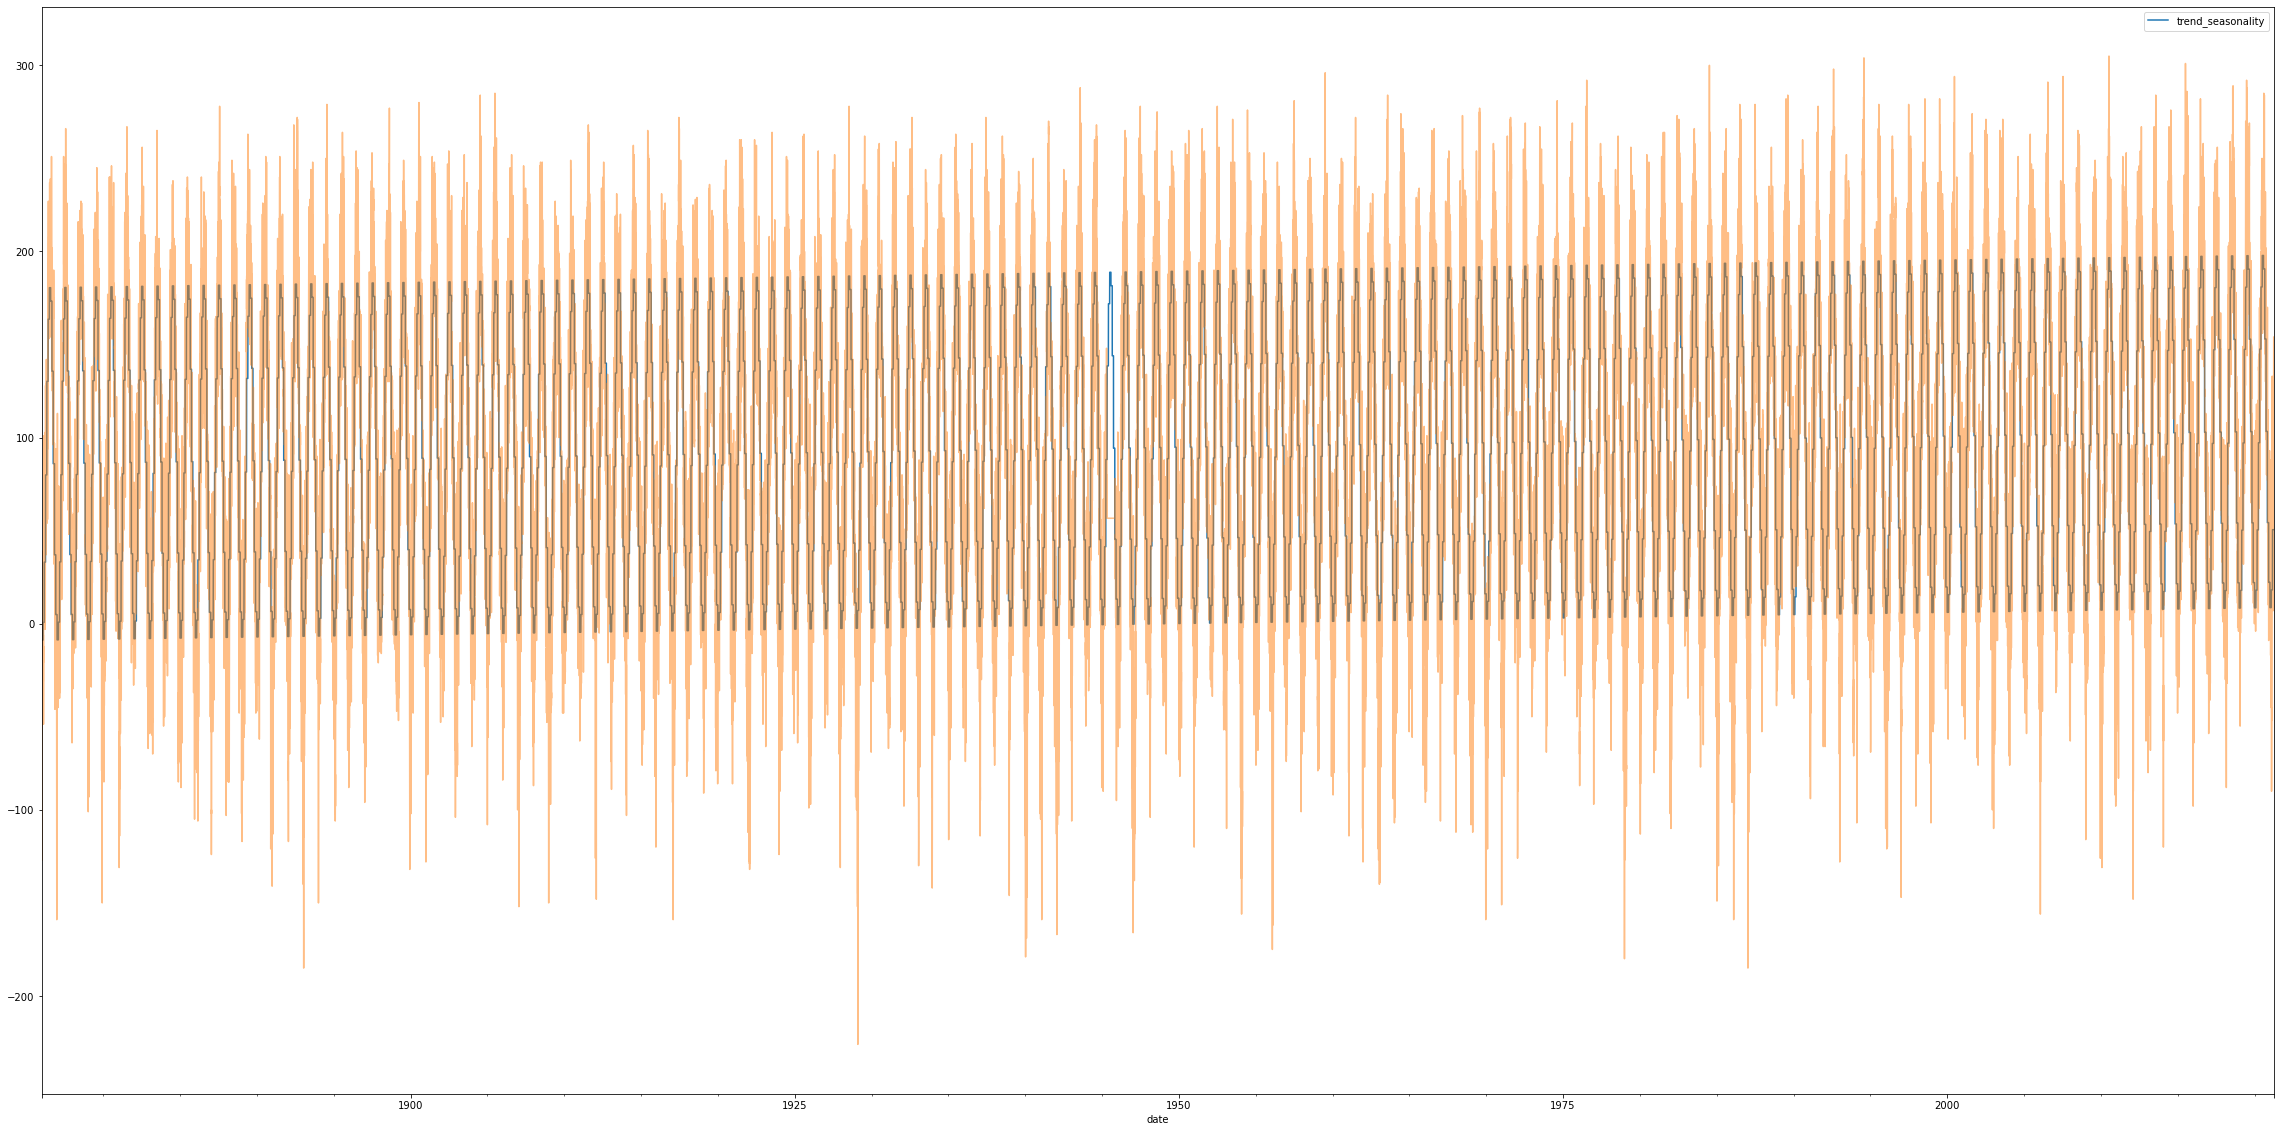

In [17]:
X = df.drop(columns=['tg','trend'])
y = df['tg']
model = LinearRegression()    
df['trend_seasonality']=train_model(X,y, model)
#plot0(df[['seasonality','tg']],'tg v.s seasonality',alpha=0.5)
df[['trend_seasonality']].plot()
df['tg'].plot(alpha = 0.5,figsize=(40,20))

In [18]:
df['remainder'] = df['tg']-df['trend_seasonality']

<AxesSubplot:xlabel='date'>

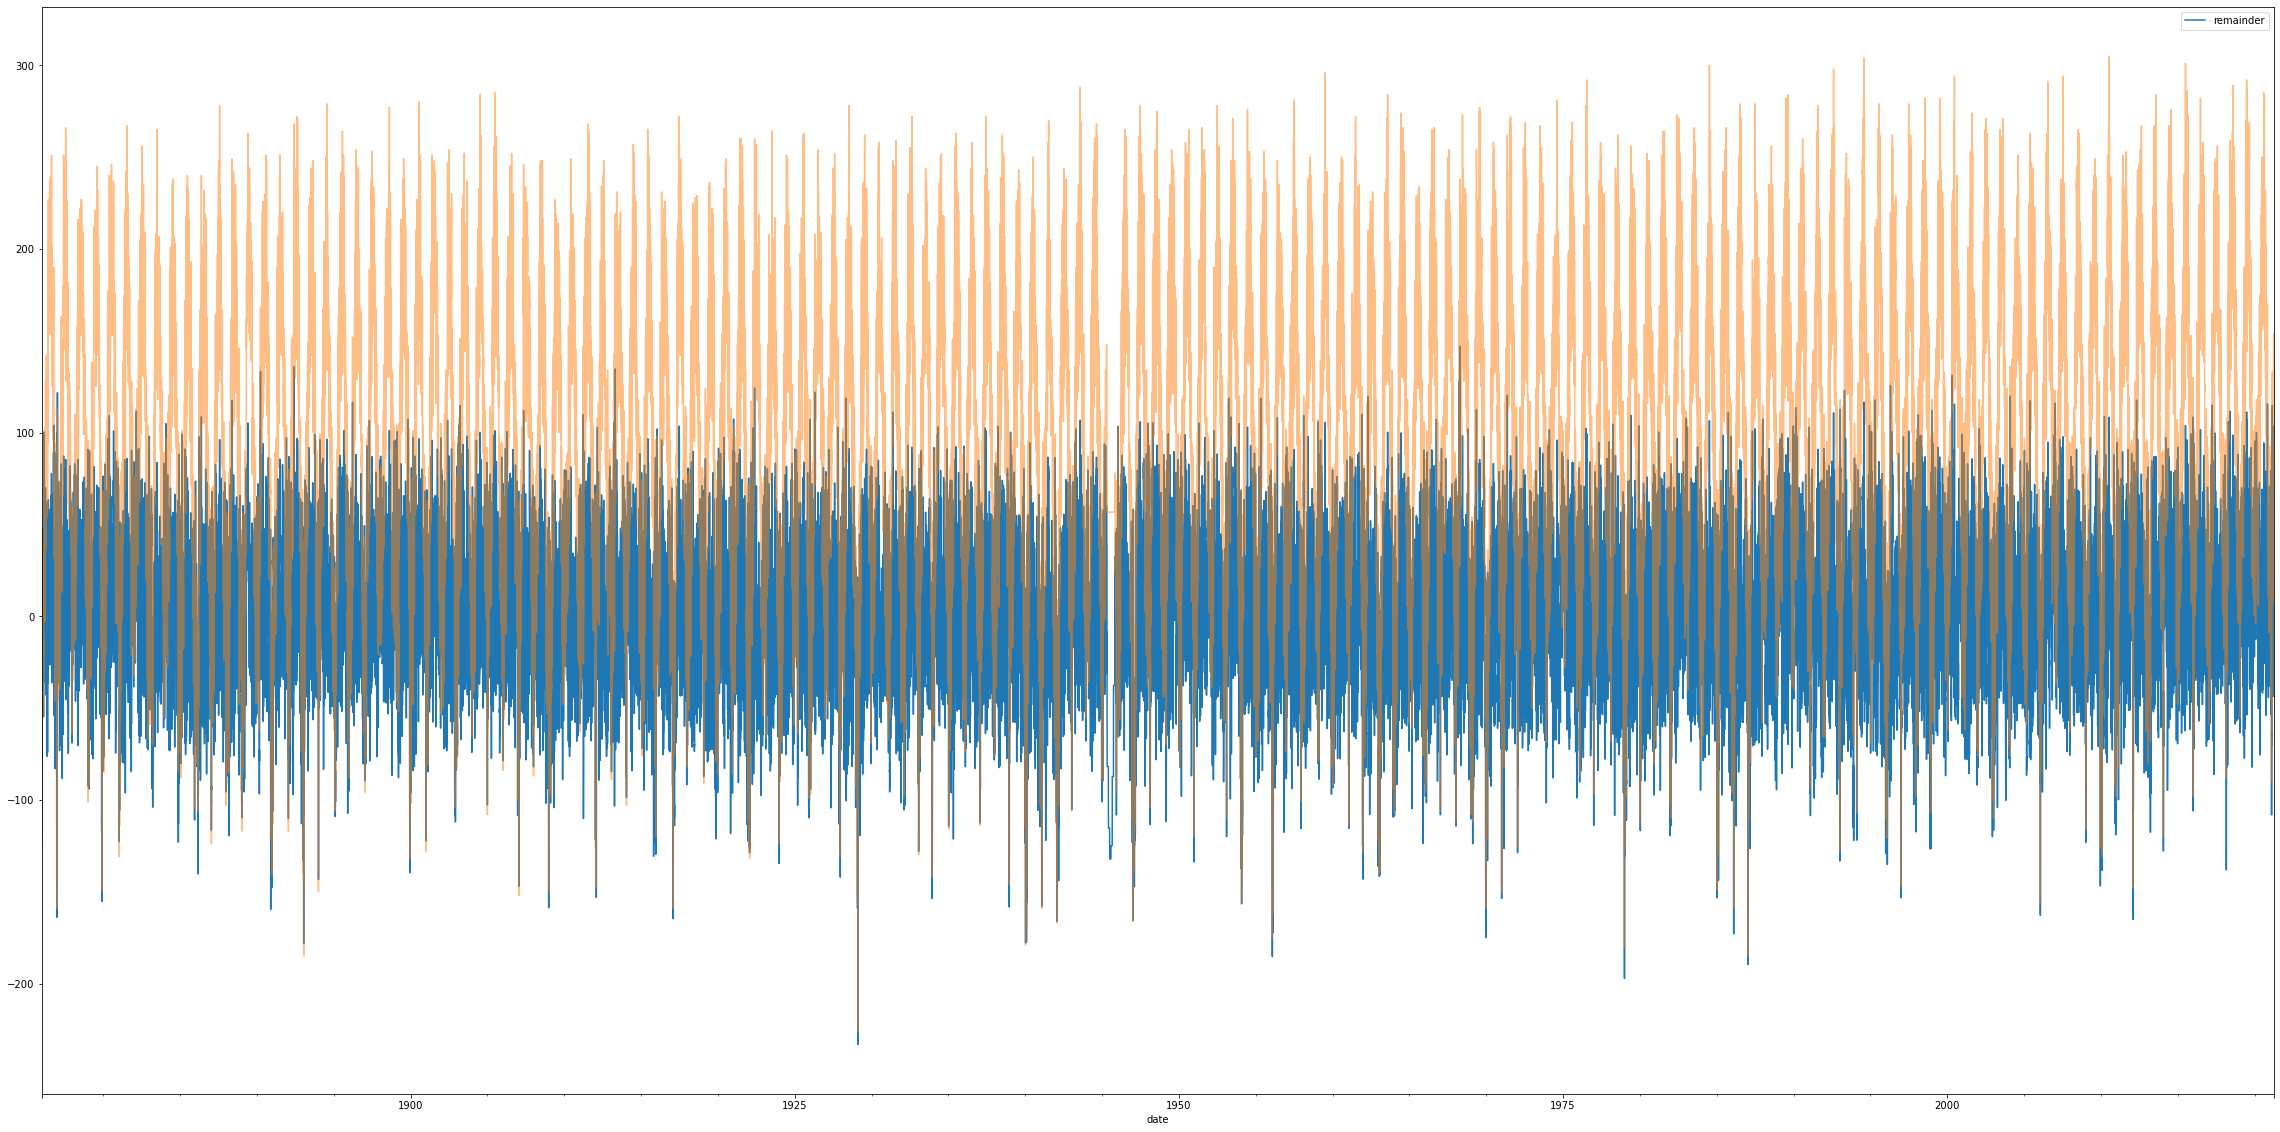

In [20]:
#plot0(df[['tg','remainder']],'remainder v.s tg')
df[['remainder']].plot()
df['tg'].plot(alpha = 0.5,figsize=(40,20))

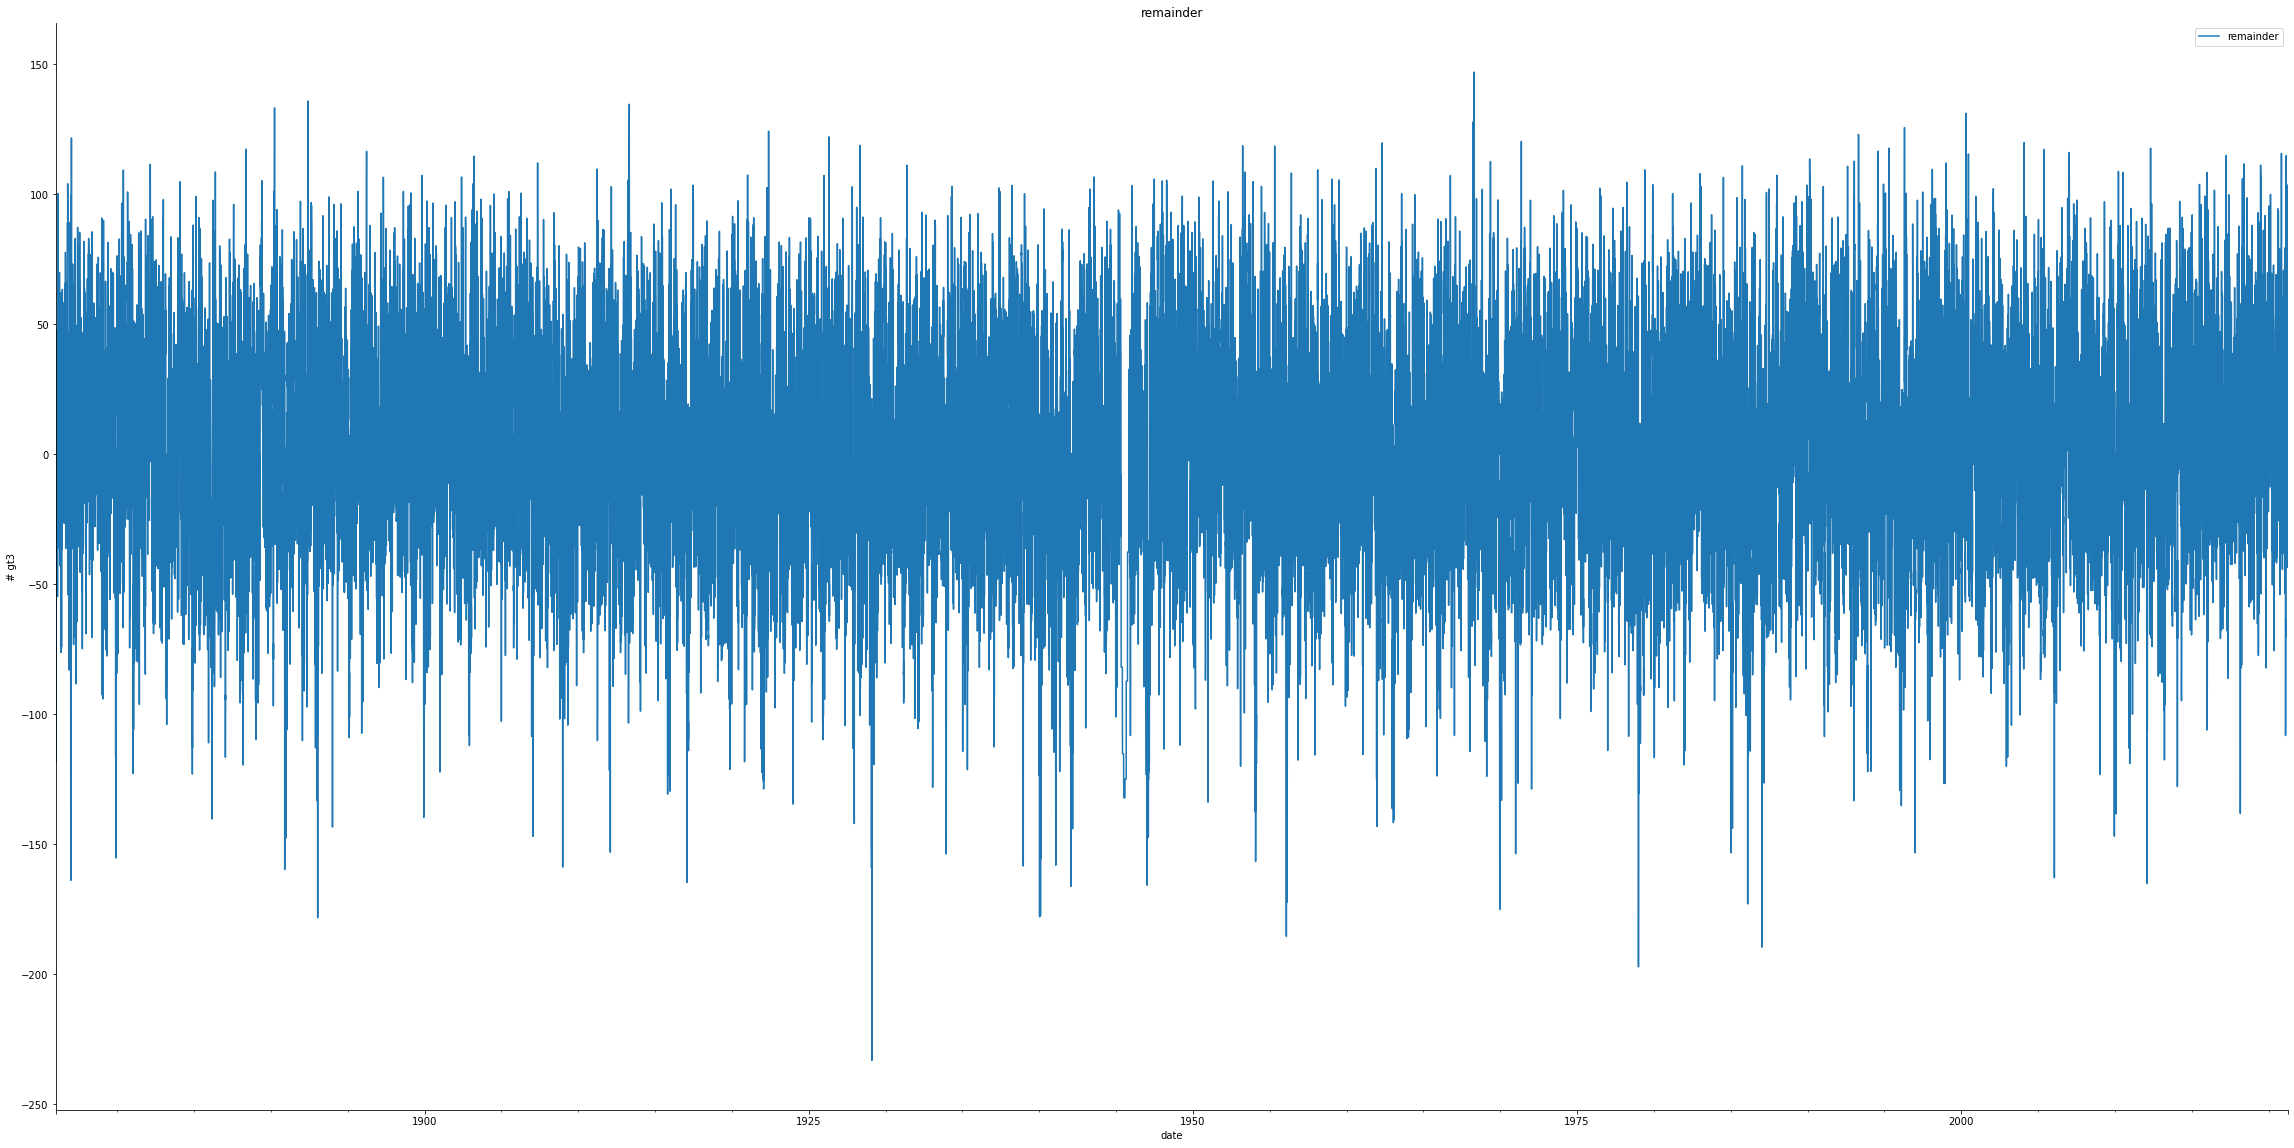

In [21]:
plot0(df[['remainder']],'remainder')

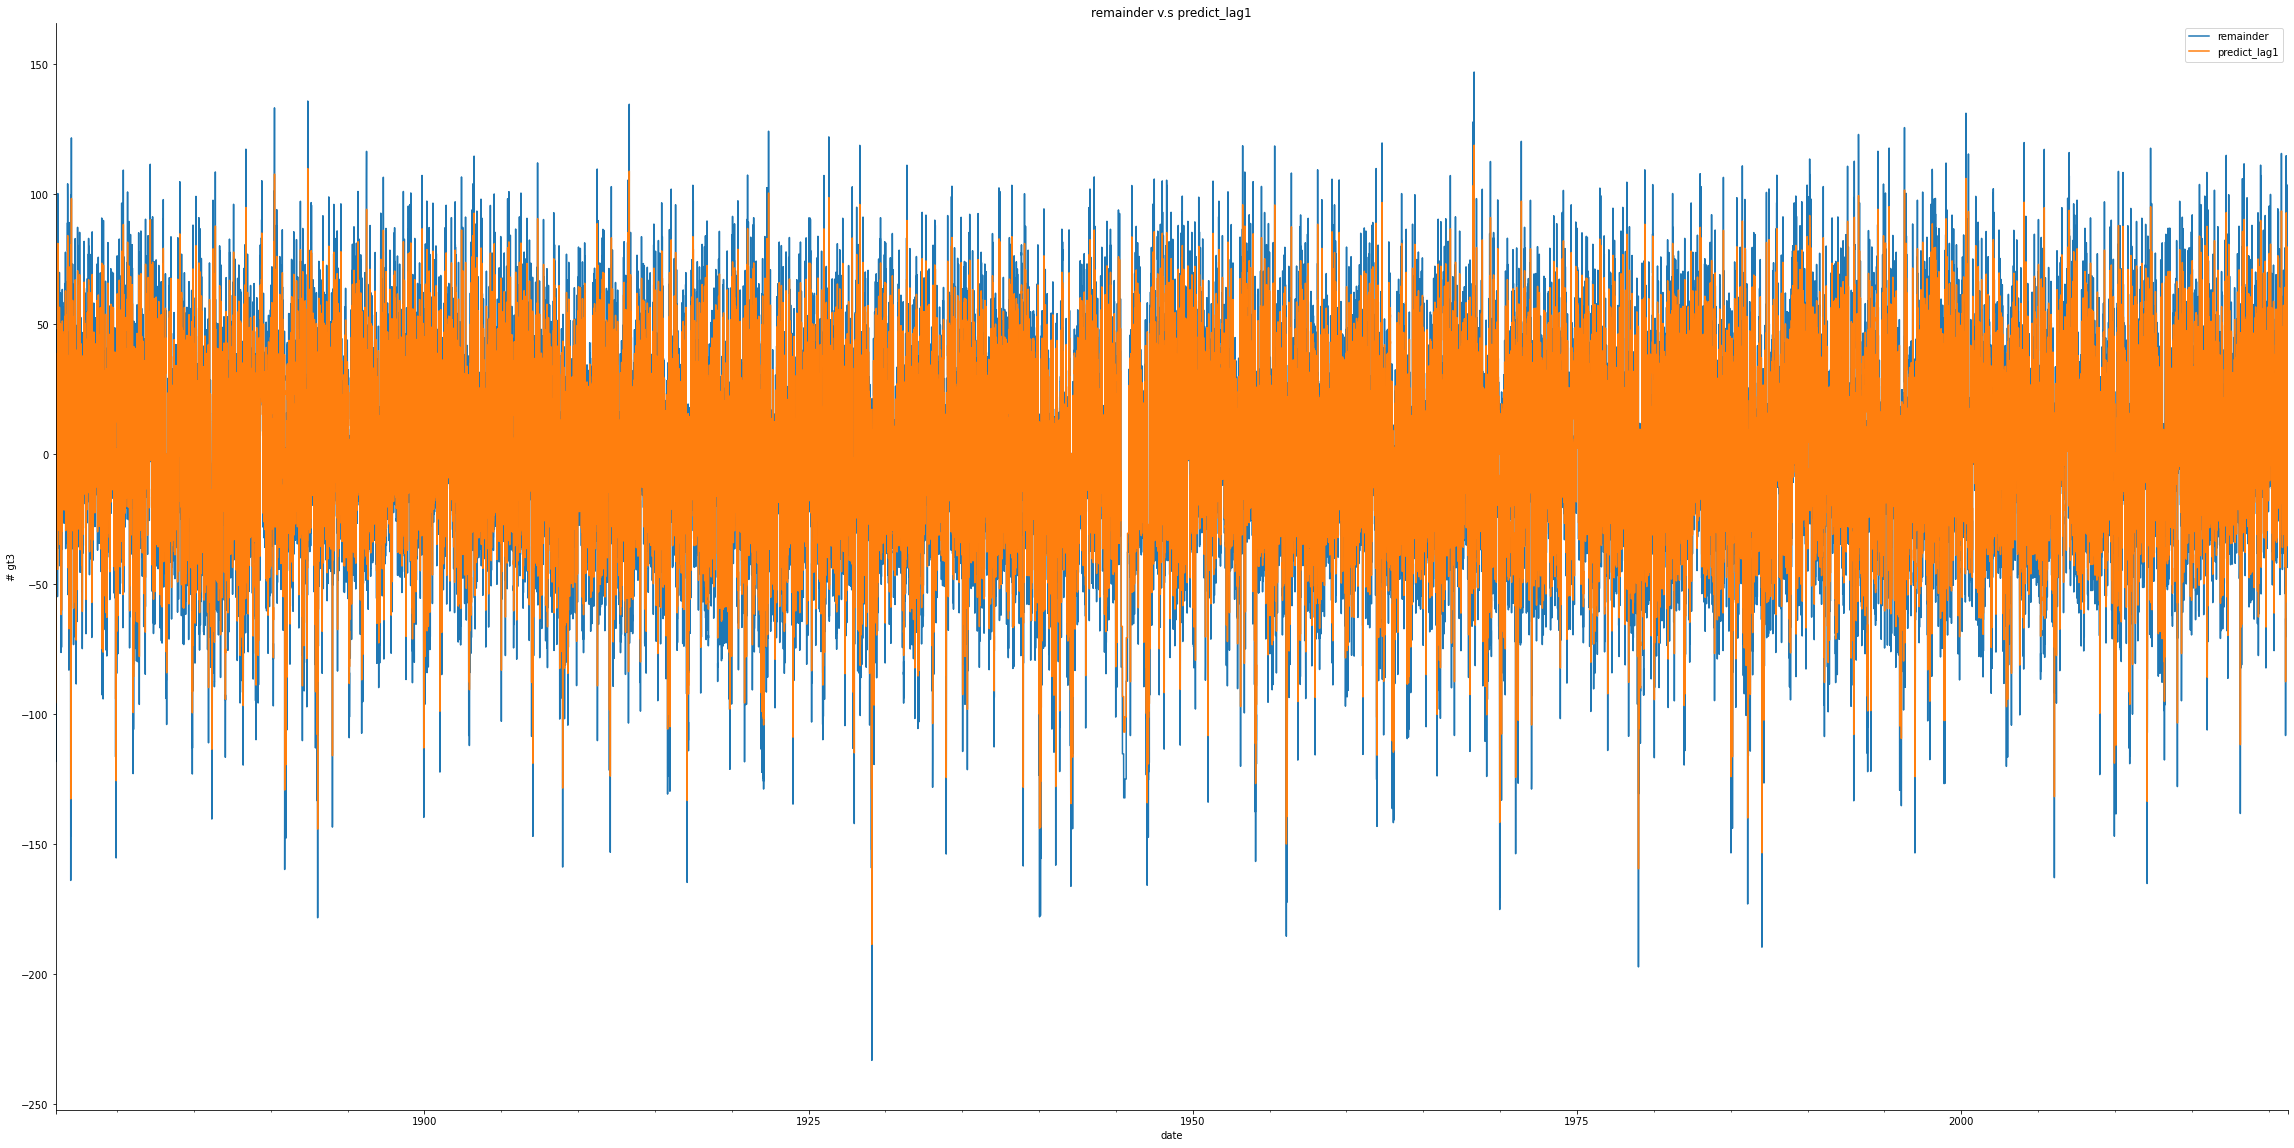

In [23]:
df['lag1_reaminder'] = df['remainder'].shift(1) # this has created nan value, need to drop.
df.dropna(inplace= True)
X_lag1 = df[['lag1_reaminder']]
y = df['remainder']
model = LinearRegression()
df['predict_lag1']=train_model(X_lag1,y,model)
plot0(df[['remainder','predict_lag1']],'remainder v.s predict_lag1') # lag1 has give good results. 

In [24]:
df.index # index is 1 less, the first date is gone, which is ok.

DatetimeIndex(['1876-01-02', '1876-01-03', '1876-01-04', '1876-01-05',
               '1876-01-06', '1876-01-07', '1876-01-08', '1876-01-09',
               '1876-01-10', '1876-01-11',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='date', length=53050, freq=None)

In [25]:
# looking to mse value and coef with lag1
from sklearn.metrics import mean_absolute_error
model.coef_, mean_absolute_error(df['remainder'], df['predict_lag1'])

(array([0.80864623]), 18.185072660302364)

In [26]:
# remainders model: ar 
# check if the remainder is stationary data, unit root check.
# check on how many lags should be used. with tools, acf, pacf and ar_select_order
# build ar model. 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

In [27]:
[t,p,c,r]= adfuller(df['remainder'], maxlag=12, regression='ctt', autolag='AIC', store= False, regresults= True)

In [28]:
t,p,c, r.usedlag, r.nobs #t-statistic, p-value, critical-value
# t is -64, smaller than critical-value, and p is 0, which is smaller than 0.05. The remainder is smaller. 

(-56.07687134382098,
 0.0,
 {'1%': -4.371348484887707,
  '5%': -3.8325013445103093,
  '10%': -3.553328996263554},
 7,
 53042)

In [29]:
r.resols.summary(),r.resols.params # more information, if want to know. But i do not understand them all. 

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.117
 Model:                            OLS   Adj. R-squared:                  0.117
 Method:                 Least Squares   F-statistic:                     704.1
 Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
 Time:                        12:52:22   Log-Likelihood:            -2.4175e+05
 No. Observations:               53042   AIC:                         4.835e+05
 Df Residuals:                   53031   BIC:                         4.836e+05
 Df Model:                          10                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

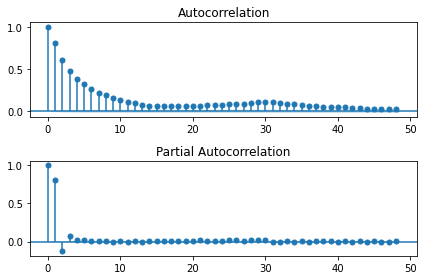

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1)
plot_acf(df['remainder'], ax=axes[0])
plot_pacf(df['remainder'], ax=axes[1])

plt.tight_layout()
plt.show()  # suggest that lag1 is enough. 

In [31]:
# check on best lags to use for remainder ar model.
from statsmodels.tsa.ar_model import ar_select_order
selected_order = ar_select_order(df['remainder'], maxlag = 12)

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names

In [32]:
selected_order.ar_lags # suggest lag 1,2,3,4,5.

array([1, 2, 3, 4, 5])

In [33]:
from statsmodels.tsa.ar_model import AutoReg

In [116]:
ar = AutoReg(endog=df['remainder'],lags=1).fit()

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [117]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                53047
Model:                     AutoReg(1)   Log Likelihood             -242408.839
Method:               Conditional MLE   S.D. of innovations             23.356
Date:                Fri, 30 Apr 2021   AIC                              6.302
Time:                        13:38:57   BIC                              6.302
Sample:                    01-06-1876   HQIC                             6.302
                         - 03-31-2021                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0032      0.101      0.031      0.975      -0.196       0.202
remainder.L1     0.8086      0.003    316.549      0.000       0.804       0.814
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2367           +0.0000j            1.2367            0.0000
-----------------------------------------------------------------------------
"""

In [154]:
ts_split = TimeSeriesSplit(n_splits = 5)
rmBe = []
for train_index, test_index in ts_split.split(df[['remainder']]):
    cv_train, cv_test = df[['remainder']].iloc[train_index], df[['remainder']].iloc[test_index]
    arma = ARIMA(cv_train,(2,2,0)).fit()
    prediction = arma.predict(cv_test.index.values[0],cv_test.index.values[-1])
    true_values=cv_test.values
    rmBe.append(mean_absolute_error(true_values,prediction))
    print(rmBe)
    print("RMBE: {}".format(np.mean(rmBe)))

/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

[30.92016403681268]
RMBE: 30.92016403681268
[30.92016403681268, 33.076014860664614]
RMBE: 31.998089448738646


/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

[30.92016403681268, 33.076014860664614, 31.05913397215936]
RMBE: 31.685104289878883


/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

[30.92016403681268, 33.076014860664614, 31.05913397215936, 31.81309960351194]
RMBE: 31.71710311828715


/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/lilycheng/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provi

[30.92016403681268, 33.076014860664614, 31.05913397215936, 31.81309960351194, 31.148437193753608]
RMBE: 31.603369933380442


In [38]:
df['ar_prediction']=ar.predict()

In [39]:
df['total_ar_prediction']=df['trend_seasonality']+df['ar_prediction']

<AxesSubplot:xlabel='date'>

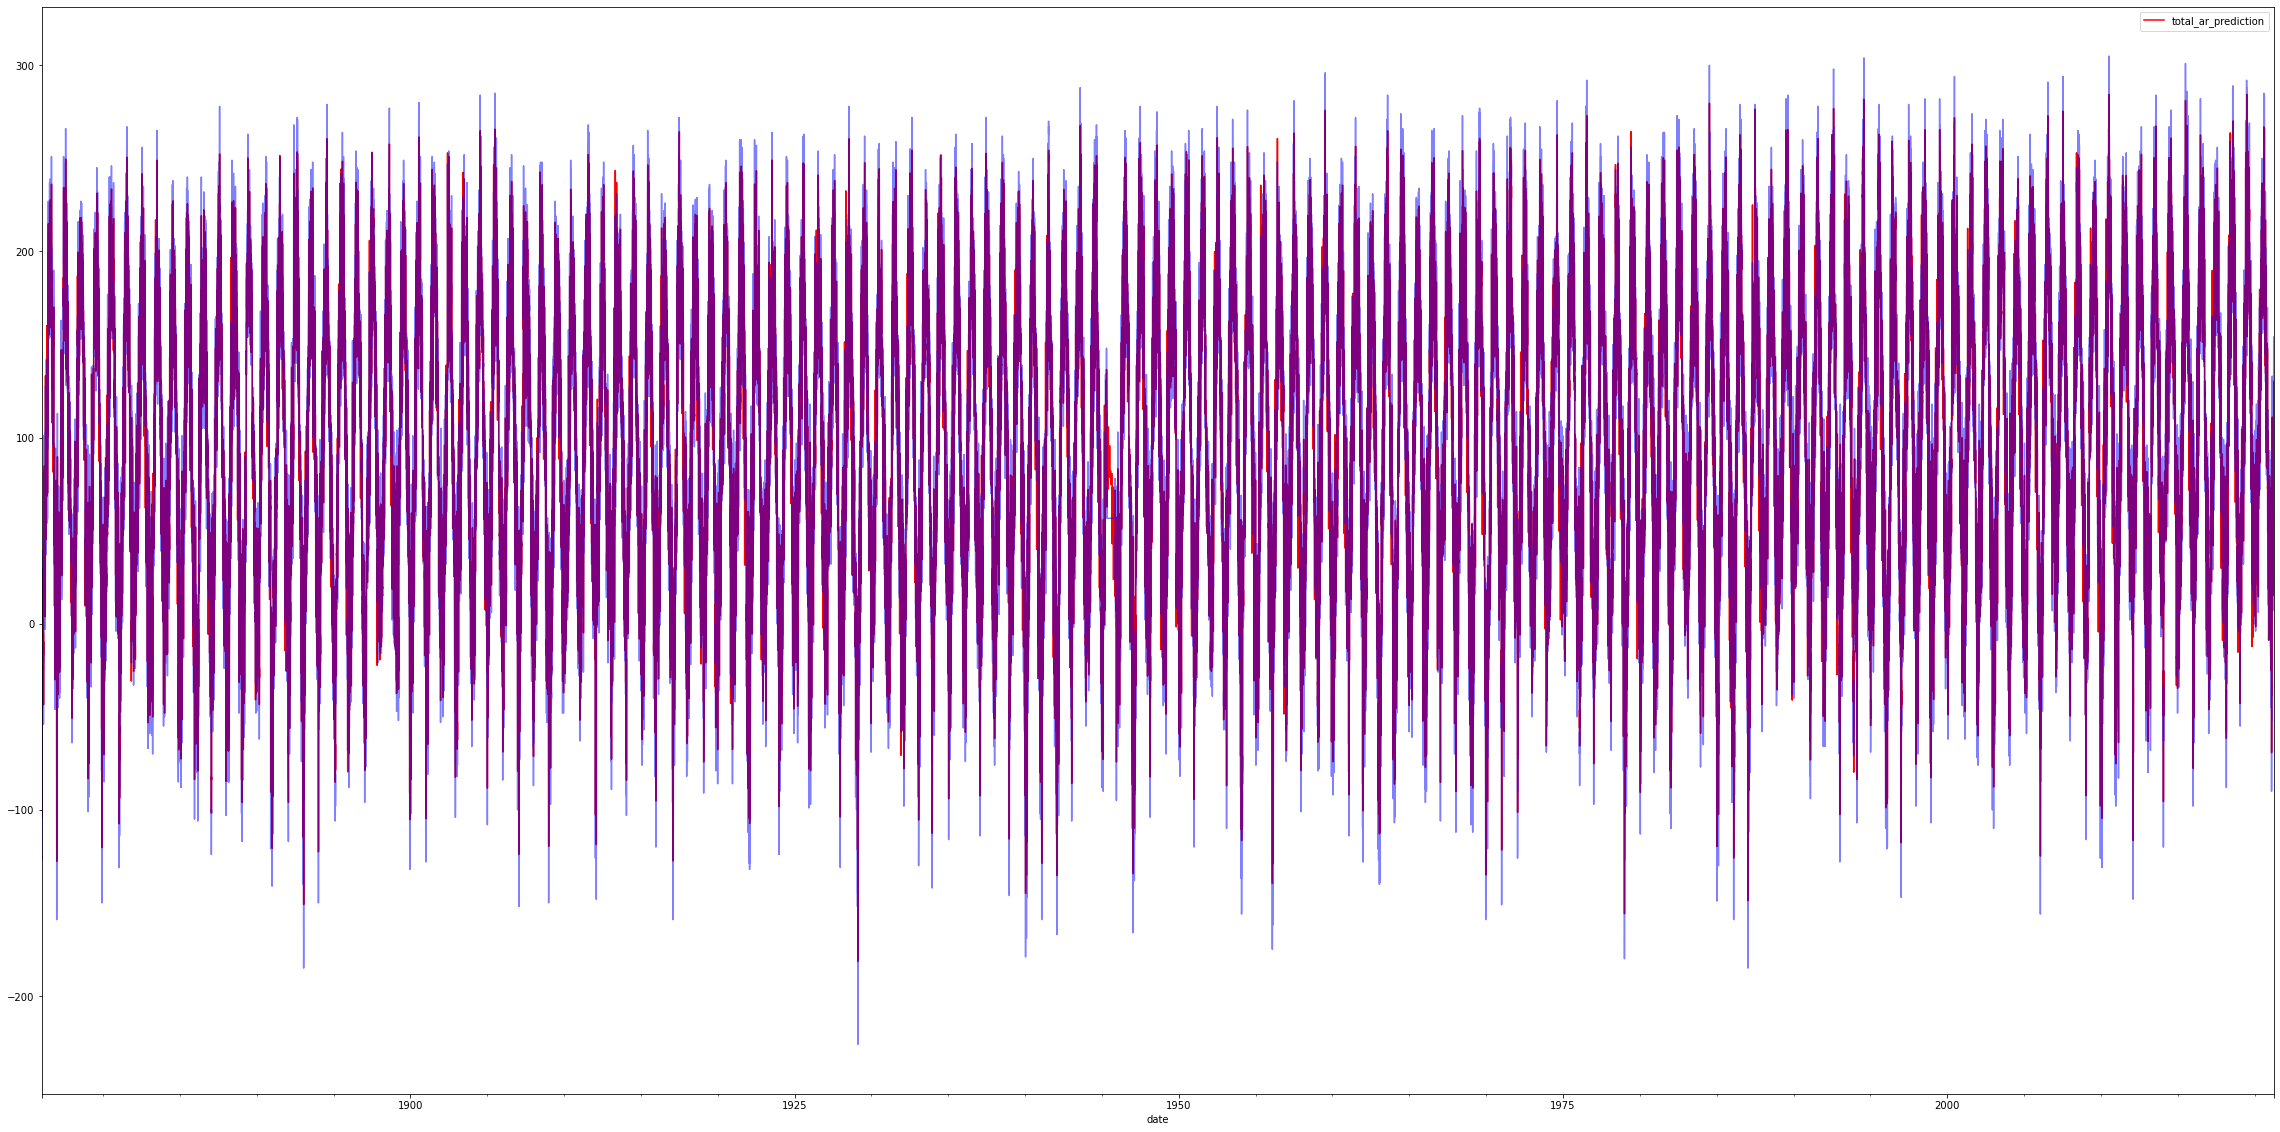

In [41]:
#plot0(df[['tg','total_prediction']],'prediction result') #?
df[['total_ar_prediction']].plot(alpha=1.0, color='r')
df['tg'].plot(alpha = 0.5,figsize=(40,20),color='b')

In [42]:
df['total_ar_prediction']
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)

In [43]:
mean_absolute_error(df['total_ar_prediction'],df['tg'])

18.185253484320853

In [44]:
mbe = []
for m,n in zip(df['total_ar_prediction'], df['tg']):
    mbe.append(np.abs(m-n))

In [45]:
def accumu(lis):
    total = 0
    for x in lis:
        total += x
        yield total
        
df['mbe_ar']=list(accumu(mbe))

<AxesSubplot:xlabel='date'>

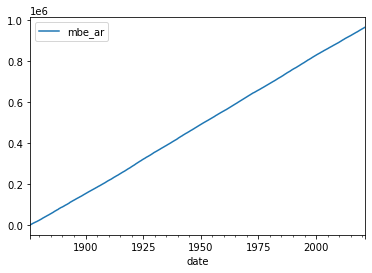

In [46]:
df[['mbe_ar']].plot()

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
arima = ARIMA(df['remainder'], order = (1,2,0)).fit() # p,q,d

In [49]:
df['arima_predict']=arima.predict()
df['arima_predict']

date
1876-01-03          NaN
1876-01-04          NaN
1876-01-05     0.001128
1876-01-06    -8.385535
1876-01-07   -24.360990
                ...    
2021-03-27    -1.595966
2021-03-28    21.568443
2021-03-29   -18.769581
2021-03-30   -23.562217
2021-03-31    24.763534
Name: arima_predict, Length: 53049, dtype: float64

In [50]:
df['total_arima_predict'] = df['trend_seasonality']+df['arima_predict']

In [55]:
df.drop(index=df.index[0], 
        axis=0, 
        inplace=True)

In [56]:
df['total_arima_predict']

date
1876-01-05    -8.778676
1876-01-06   -17.165010
1876-01-07   -33.140136
1876-01-08    -4.783374
1876-01-09     4.802228
                ...    
2021-03-27    48.935851
2021-03-28    72.100590
2021-03-29    31.762895
2021-03-30    26.970588
2021-03-31    75.296668
Name: total_arima_predict, Length: 53047, dtype: float64

In [58]:
mean_absolute_error(df['total_arima_predict'],df['tg'])

34.018915201782534

In [54]:
import pmdarima as pm

In [85]:
#!pip install pmdarima

In [ ]:
#m = pm.auto_arima(df['remainder'], seasonal= True, m = 5)

In [ ]:
m.predict()

In [60]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [61]:
ts_split = TimeSeriesSplit(n_splits=5)

In [69]:
df.head(5)

,tg,timestamp,trend,month__1,month__2,month__3,month__4,month__5,month__6,month__7,...,month__12,trend_seasonality,remainder,lag1_reaminder,predict_lag1,ar_prediction,total_ar_prediction,mbe_ar,arima_predict,total_arima_predict
date,,,,,,,,,,,,,,,,,,,,,
1876-01-06,-77.0,5,85.134138,1,0,0,0,0,0,0,...,0,-8.779475,-68.220525,-89.220196,-72.146578,-72.146454,-80.925929,112.092539,0.000503,-8.778972
1876-01-07,-66.0,6,85.134459,1,0,0,0,0,0,0,...,0,-8.779146,-57.220854,-68.220525,-55.165273,-55.165218,-63.944363,114.148176,-24.364562,-33.143708
1876-01-08,-89.0,7,85.134780,1,0,0,0,0,0,0,...,0,-8.778817,-80.221183,-57.220854,-46.270431,-46.270411,-55.049228,148.098948,3.995009,-4.783808
1876-01-09,-127.0,8,85.135101,1,0,0,0,0,0,0,...,0,-8.778488,-118.221512,-80.221183,-64.869560,-64.869465,-73.647953,201.450995,13.581343,4.802855
1876-01-10,-89.0,9,85.135422,1,0,0,0,0,0,0,...,0,-8.778158,-80.221842,-118.221512,-95.598383,-95.598164,-104.376322,216.827317,5.992162,-2.785996


In [65]:
X_full=df.drop(['tg','trend_seasonality','remainder','predict_lag1','total_ar_prediction','mbe_ar','arima_predict','total_arima_predict'],axis=1)

In [66]:
X_full.head()

,timestamp,trend,month__1,month__2,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,lag1_reaminder,ar_prediction
date,,,,,,,,,,,,,,,,
1876-01-05,4,85.133817,1,0,0,0,0,0,0,0,0,0,0,0,-49.219867,-39.800469
1876-01-06,5,85.134138,1,0,0,0,0,0,0,0,0,0,0,0,-89.220196,-72.146454
1876-01-07,6,85.134459,1,0,0,0,0,0,0,0,0,0,0,0,-68.220525,-55.165218
1876-01-08,7,85.134780,1,0,0,0,0,0,0,0,0,0,0,0,-57.220854,-46.270411
1876-01-09,8,85.135101,1,0,0,0,0,0,0,0,0,0,0,0,-80.221183,-64.869465


In [67]:
y_full = df['tg']

In [78]:
lr = LinearRegression()

In [79]:
lr.fit(X_full,y_full)

LinearRegression()

In [70]:
time_series_split=ts_split.split(X_full, y_full)

In [71]:
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f'The training data for the {i+1}th iteration are the observations {train_index}')
    print(f'The validation data for the {i+1}th iteration are the observations {validation_index}')
    print()

The training data for the 1th iteration are the observations [   0    1    2 ... 8839 8840 8841]
The validation data for the 1th iteration are the observations [ 8842  8843  8844 ... 17680 17681 17682]

The training data for the 2th iteration are the observations [    0     1     2 ... 17680 17681 17682]
The validation data for the 2th iteration are the observations [17683 17684 17685 ... 26521 26522 26523]

The training data for the 3th iteration are the observations [    0     1     2 ... 26521 26522 26523]
The validation data for the 3th iteration are the observations [26524 26525 26526 ... 35362 35363 35364]

The training data for the 4th iteration are the observations [    0     1     2 ... 35362 35363 35364]
The validation data for the 4th iteration are the observations [35365 35366 35367 ... 44203 44204 44205]

The training data for the 5th iteration are the observations [    0     1     2 ... 44203 44204 44205]
The validation data for the 5th iteration are the observations [442

In [80]:
cross_val_score(estimator=lr, X=X_full, y=y_full, cv=time_series_split)

array([0.9032323 , 0.91017825, 0.91147175, 0.90734815, 0.91529584])